In [95]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import plotly.express as px

from sql_server import engine

from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import log_loss

Confusion Matrix plot function.

In [96]:
def plot_confusion_matrix(y, y_predict):
    LABELS = ['Others', 'Top Points']
    conf_matrix = confusion_matrix(y, y_predict)

    plt.figure()
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

### Load Data

In [97]:
df = pd.read_sql_query('''\
                       select * from ml_data_2
                       ''', engine)

In [98]:
df.head()

,gameweek,web_name,first_name,position,team,event_points,in_dreamteam,gameweek_goals,gameweek_assists,gameweek_saves,gameweek_cleansheet,team_strength_diff,own_goals_per_90,penalties_saved_per_90,penalties_missed_per_90,points_per_game,yellow_cards_per_90,red_cards_per_90,influence,creativity,threat,goals_scored_per_90,assists_per_90,saves_per_90,goals_conceded_per_90,starts_per_90,clean_sheets_per_90
0,23,A.Becker,Alisson,Goalkeeper,Liverpool,9,False,0,0,4,1,280,0.0,0.0,0.0,4.2,0.000000,0.0,271.6,13.0,0.0,0.0,0.0000,2.31,0.87,1.01,0.43
1,23,A.Doucoure,Abdoulaye,Midfielder,Everton,8,False,1,0,0,1,-15,0.0,0.0,0.0,2.2,0.113136,0.0,145.0,226.4,106.0,0.0,0.0000,0.00,1.19,1.07,0.45
2,23,A.Fatawu,Abdul,Midfielder,Leicester,0,False,0,0,0,0,-65,0.0,0.0,0.0,2.4,0.000000,0.0,147.6,104.3,148.0,0.0,0.3125,0.00,2.19,0.94,0.00
3,23,Aarons,Max,Defender,Bournemouth,0,False,0,0,0,0,-25,0.0,0.0,0.0,2.7,0.000000,0.0,13.2,3.2,0.0,0.0,0.0000,0.00,0.00,1.07,1.07
4,23,Acheampong,Josh,Defender,Chelsea,0,False,0,0,0,0,5,0.0,0.0,0.0,1.5,0.000000,0.0,12.6,1.5,13.0,0.0,0.0000,0.00,1.69,1.12,0.00


In [99]:
dummies = pd.get_dummies(df.position)
df = pd.concat([df, dummies], axis='columns')

In [100]:
df.shape

(1869, 31)

In [101]:
df.dtypes

gameweek                     int64
web_name                    object
first_name                  object
position                    object
team                        object
event_points                 int64
in_dreamteam                  bool
gameweek_goals               int64
gameweek_assists             int64
gameweek_saves               int64
gameweek_cleansheet          int64
team_strength_diff           int64
own_goals_per_90           float64
penalties_saved_per_90     float64
penalties_missed_per_90    float64
points_per_game             object
yellow_cards_per_90        float64
red_cards_per_90           float64
influence                   object
creativity                  object
threat                      object
goals_scored_per_90        float64
assists_per_90             float64
saves_per_90               float64
goals_conceded_per_90      float64
starts_per_90              float64
clean_sheets_per_90        float64
Defender                      bool
Forward             

In [102]:
df[['in_dreamteam', 'Defender', 'Forward', 'Goalkeeper', 'Midfielder']] = df[['in_dreamteam', 'Defender', 'Forward', 'Goalkeeper', 'Midfielder']].astype(int)
df[['points_per_game', 'influence', 'creativity', 'threat']] = df[['points_per_game', 'influence', 'creativity', 'threat']].astype(float)

In [103]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gameweek,1869.0,24.482611,1.192115,23.0,23.00,24.000000,26.000000,27.000000
event_points,1869.0,1.612627,2.691841,-3.0,0.00,1.000000,2.000000,21.000000
in_dreamteam,1869.0,0.020332,0.141170,0.0,0.00,0.000000,0.000000,1.000000
gameweek_goals,1869.0,0.056180,0.268931,0.0,0.00,0.000000,0.000000,3.000000
gameweek_assists,1869.0,0.049224,0.248627,0.0,0.00,0.000000,0.000000,3.000000
gameweek_saves,1869.0,0.119315,0.692725,0.0,0.00,0.000000,0.000000,8.000000
gameweek_cleansheet,1869.0,0.116640,0.321077,0.0,0.00,0.000000,0.000000,1.000000
team_strength_diff,1869.0,-3.611557,110.351351,-280.0,-70.00,-5.000000,65.000000,280.000000
own_goals_per_90,1849.0,0.003527,0.021198,0.0,0.00,0.000000,0.000000,0.238727
penalties_saved_per_90,1849.0,0.000638,0.006668,0.0,0.00,0.000000,0.000000,0.125000


<Axes: xlabel='goals_conceded_per_90'>

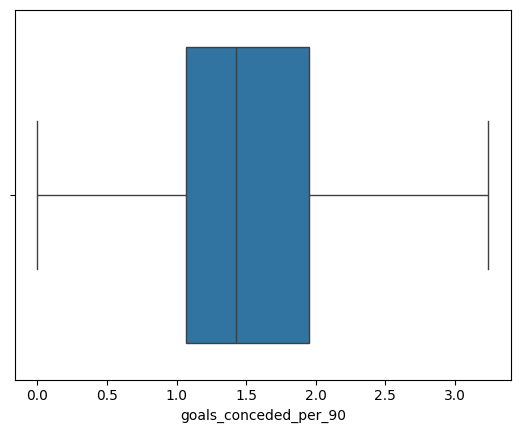

In [104]:
sns.boxplot(df[df['goals_conceded_per_90'] < 3.3], x='goals_conceded_per_90')

In [105]:
df = df[df['goals_conceded_per_90'] < 3.3]

In [106]:
df.isnull().sum()

gameweek                   0
web_name                   0
first_name                 0
position                   0
team                       0
event_points               0
in_dreamteam               0
gameweek_goals             0
gameweek_assists           0
gameweek_saves             0
gameweek_cleansheet        0
team_strength_diff         0
own_goals_per_90           0
penalties_saved_per_90     0
penalties_missed_per_90    0
points_per_game            0
yellow_cards_per_90        0
red_cards_per_90           0
influence                  0
creativity                 0
threat                     0
goals_scored_per_90        0
assists_per_90             0
saves_per_90               0
goals_conceded_per_90      0
starts_per_90              0
clean_sheets_per_90        0
Defender                   0
Forward                    0
Goalkeeper                 0
Midfielder                 0
dtype: int64

In [107]:
df = df.dropna()

C:\Users\kakaf\AppData\Local\Temp\ipykernel_12520\1989196770.py:2: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[Text(0, 0, 'false'), Text(1, 0, 'true')]

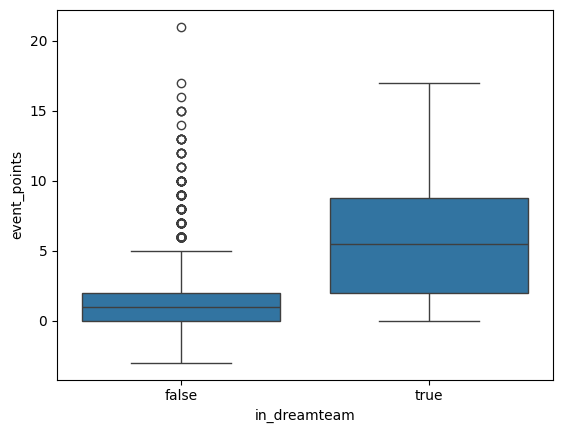

In [108]:
g = sns.boxplot(x='in_dreamteam', y='event_points', data=df)
g.set_xticklabels(['false', 'true'])

In [110]:
df.columns

Index(['gameweek', 'web_name', 'first_name', 'position', 'team',
       'event_points', 'in_dreamteam', 'gameweek_goals', 'gameweek_assists',
       'gameweek_saves', 'gameweek_cleansheet', 'team_strength_diff',
       'own_goals_per_90', 'penalties_saved_per_90', 'penalties_missed_per_90',
       'points_per_game', 'yellow_cards_per_90', 'red_cards_per_90',
       'influence', 'creativity', 'threat', 'goals_scored_per_90',
       'assists_per_90', 'saves_per_90', 'goals_conceded_per_90',
       'starts_per_90', 'clean_sheets_per_90', 'Defender', 'Forward',
       'Goalkeeper', 'Midfielder'],
      dtype='object')

In [ ]:
def pred_logreg_cv(data, position):
    print('Logistic Regression: ')
    data = data[data[position] == 1]
    top_point = data['event_points'].quantile(0.9)
    data = data.assign(top_points=[1 if x > top_point else 0 for x in data['event_points']])

    X = data.drop(['gameweek', 'web_name', 'first_name', 'position', 'team', 
        'event_points', 'in_dreamteam', 'gameweek_goals', 'gameweek_assists', 'gameweek_saves', 'gameweek_cleansheet', 'top_points'], axis=1)

    y = data['top_points'].to_numpy()

    transform = preprocessing.StandardScaler()
    X = transform.fit(X).transform(X.astype(float))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    parameters = {
        'C':[0.01, 0.1, 1],
        'penalty':['l2'],
        'solver':['lbfgs']
    }

    lr = LogisticRegression()
    logreg_cv = GridSearchCV(lr, parameters, cv=10).fit(X_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
    print("accuracy :", logreg_cv.best_score_)
    print('score :', logreg_cv.score(X_test, y_test))

    yhat = logreg_cv.predict(X_test)
    plot_confusion_matrix(y_test, yhat)

    print(classification_report(y_test, yhat))

    joblib.dump(logreg_cv.best_estimator_, position+'_logreg.joblib', compress=1)

    return logreg_cv.best_score_
    print('==================================================')

def pred_tree_cv(data, position):
    print('Decision Tree: ')
    data = data[data[position] == 1]
    top_point = data['event_points'].quantile(0.9)
    data = data.assign(top_points=[1 if x > top_point else 0 for x in data['event_points']])

    X = data.drop(['gameweek', 'web_name', 'first_name', 'position', 'team', 
        'event_points', 'in_dreamteam', 'gameweek_goals', 'gameweek_assists', 'gameweek_saves', 'gameweek_cleansheet', 'top_points'], axis=1)

    y = data['top_points'].to_numpy()

    transform = preprocessing.StandardScaler()
    X = transform.fit(X).transform(X.astype(float))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    parameters = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [2*n for n in range(1,10)],
        'max_features': ['log2', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10]
    }

    tree = DecisionTreeClassifier()
    tree_cv = GridSearchCV(tree, parameters, cv=10).fit(X_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", tree_cv.best_params_)
    print("accuracy :", tree_cv.best_score_)
    print('score :', tree_cv.score(X_test, y_test))

    yhat = tree_cv.predict(X_test)
    plot_confusion_matrix(y_test, yhat)

    print(classification_report(y_test, yhat))

    joblib.dump(tree_cv.best_estimator_, position+'_tree.joblib', compress=1)

    return tree_cv.best_score_
    print('==================================================')

def pred_knn_cv(data, position):
    print('KNN: ')
    data = data[data[position] == 1]
    top_point = data['event_points'].quantile(0.9)
    data = data.assign(top_points=[1 if x > top_point else 0 for x in data['event_points']])

    X = data.drop(['gameweek', 'web_name', 'first_name', 'position', 'team', 
        'event_points', 'in_dreamteam', 'gameweek_goals', 'gameweek_assists', 'gameweek_saves', 'gameweek_cleansheet', 'top_points'], axis=1)

    y = data['top_points'].to_numpy()

    transform = preprocessing.StandardScaler()
    X = transform.fit(X).transform(X.astype(float))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    parameters = {
        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1,2]
    }

    KNN = KNeighborsClassifier()
    knn_cv = GridSearchCV(KNN, parameters, cv=10).fit(X_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", knn_cv.best_params_)
    print("accuracy :", knn_cv.best_score_)
    print('score :', knn_cv.score(X_test, y_test))

    yhat = knn_cv.predict(X_test)
    plot_confusion_matrix(y_test, yhat)

    print(classification_report(y_test, yhat))

    joblib.dump(knn_cv, position+'_knn.joblib', compress=1)

    return knn_cv.best_score_
    print('==================================================')

def pred_svc_cv(data, position):
    print('SVM: ')
    data = data[data[position] == 1]
    top_point = data['event_points'].quantile(0.9)
    data = data.assign(top_points=[1 if x > top_point else 0 for x in data['event_points']])

    X = data.drop(['gameweek', 'web_name', 'first_name', 'position', 'team', 
        'event_points', 'in_dreamteam', 'gameweek_goals', 'gameweek_assists', 'gameweek_saves', 'gameweek_cleansheet', 'top_points'], axis=1)

    y = data['top_points'].to_numpy()

    transform = preprocessing.StandardScaler()
    X = transform.fit(X).transform(X.astype(float))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    parameters = {
        'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid'),
        'C': np.logspace(-3, 3, 5),
        'gamma':np.logspace(-3, 3, 5)
    }

    svm = SVC()
    svm_cv = GridSearchCV(svm, parameters, cv=2).fit(X_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", svm_cv.best_params_)
    print("accuracy :", svm_cv.best_score_)
    print('score :', svm_cv.score(X_test, y_test))

    yhat = svm_cv.predict(X_test)
    plot_confusion_matrix(y_test, yhat)

    print(classification_report(y_test, yhat))

    joblib.dump(svm_cv, position+'_svc.joblib', compress=1)

    return svm_cv.best_score_
    print('==================================================')

In [112]:
def model_by_position(position):
    logreg_score = pred_logreg_cv(df, position)
    svm_score = pred_svc_cv(df, position)
    tree_score = pred_tree_cv(df, position)
    knn_score = pred_knn_cv(df, position)

    dict = [
        {'Model': 'logreg_cv', 'Score': logreg_score},
        {'Model': 'svm_cv', 'Score': svm_score},
        {'Model': 'tree_cv', 'Score': tree_score},
        {'Model': 'knn_cv', 'Score': knn_score}
    ]

    df_a = pd.DataFrame(dict)

    fig = px.bar(
        df_a, x='Model', y='Score',
        text_auto='.5f',
        title=position+' Model Results'
    )
    fig.show()

Logistic Regression: 
tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8444444444444444
score : 0.7368421052631579


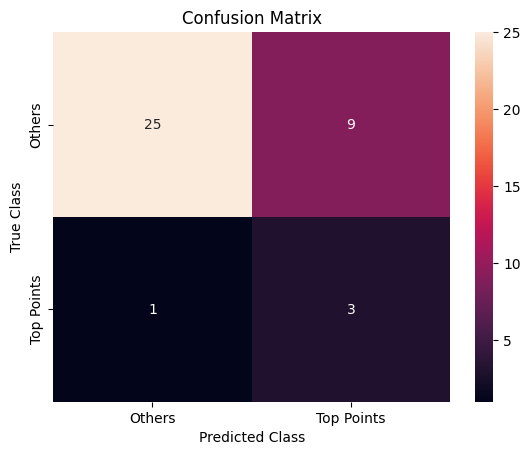

              precision    recall  f1-score   support

           0       0.96      0.74      0.83        34
           1       0.25      0.75      0.38         4

    accuracy                           0.74        38
   macro avg       0.61      0.74      0.60        38
weighted avg       0.89      0.74      0.79        38

SVM: 
tuned hpyerparameters :(best parameters)  {'C': 31.622776601683793, 'gamma': 1.0, 'kernel': 'rbf'}
accuracy : 0.9222222222222223
score : 0.8157894736842105


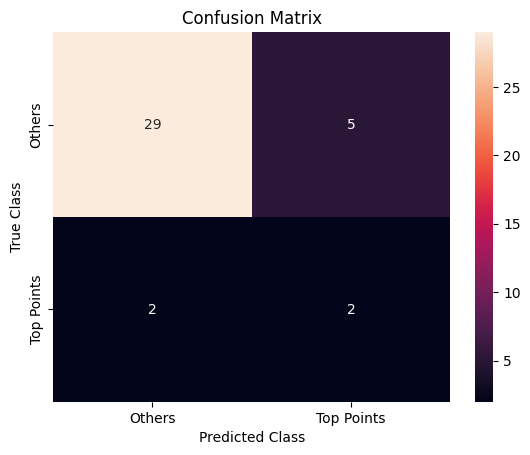

              precision    recall  f1-score   support

           0       0.94      0.85      0.89        34
           1       0.29      0.50      0.36         4

    accuracy                           0.82        38
   macro avg       0.61      0.68      0.63        38
weighted avg       0.87      0.82      0.84        38

Decision Tree: 


d:\01topan\01goals\goalsenv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning:

invalid value encountered in cast



tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.9037037037037038
score : 0.868421052631579


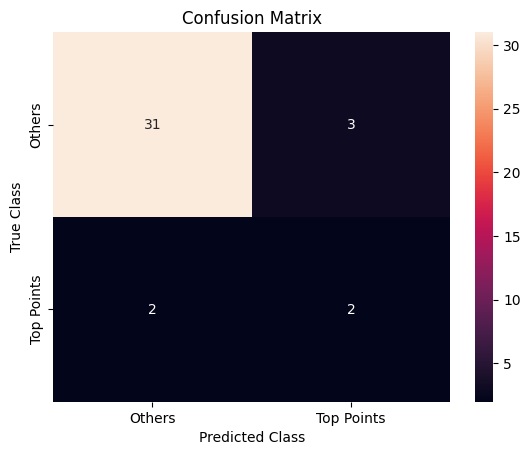

              precision    recall  f1-score   support

           0       0.94      0.91      0.93        34
           1       0.40      0.50      0.44         4

    accuracy                           0.87        38
   macro avg       0.67      0.71      0.68        38
weighted avg       0.88      0.87      0.87        38

KNN: 
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1}
accuracy : 0.937037037037037
score : 0.8157894736842105


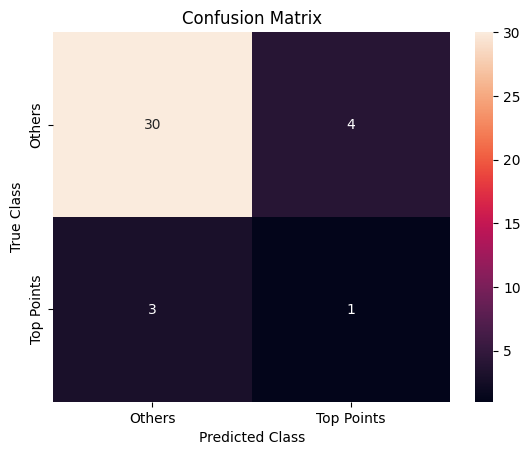

              precision    recall  f1-score   support

           0       0.91      0.88      0.90        34
           1       0.20      0.25      0.22         4

    accuracy                           0.82        38
   macro avg       0.55      0.57      0.56        38
weighted avg       0.83      0.82      0.82        38



In [113]:
model_by_position('Forward')

Logistic Regression: 


tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.6958333333333333
score : 0.7393939393939394


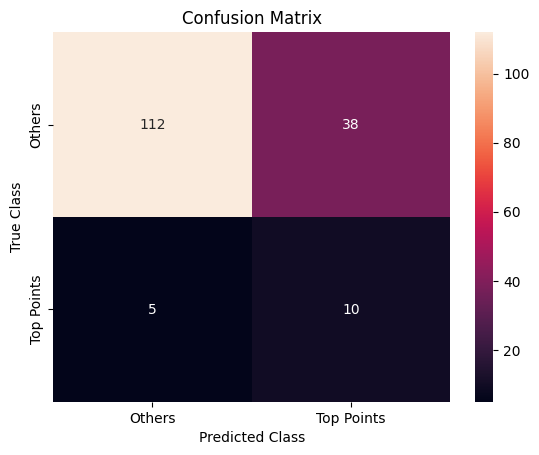

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       150
           1       0.21      0.67      0.32        15

    accuracy                           0.74       165
   macro avg       0.58      0.71      0.58       165
weighted avg       0.89      0.74      0.79       165

SVM: 
tuned hpyerparameters :(best parameters)  {'C': 31.622776601683793, 'gamma': 1.0, 'kernel': 'rbf'}
accuracy : 0.9199999999999999
score : 0.8848484848484849


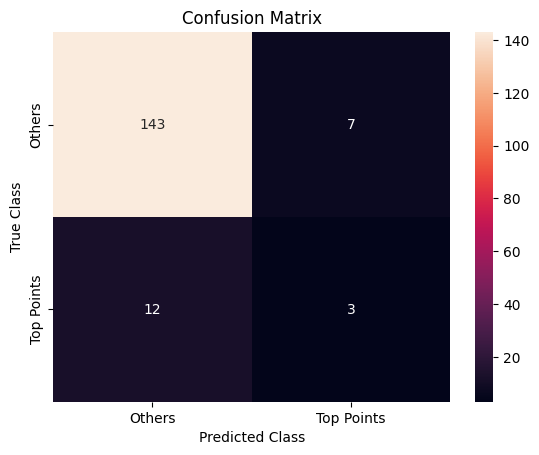

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       150
           1       0.30      0.20      0.24        15

    accuracy                           0.88       165
   macro avg       0.61      0.58      0.59       165
weighted avg       0.87      0.88      0.87       165

Decision Tree: 
tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
accuracy : 0.8783333333333333
score : 0.806060606060606


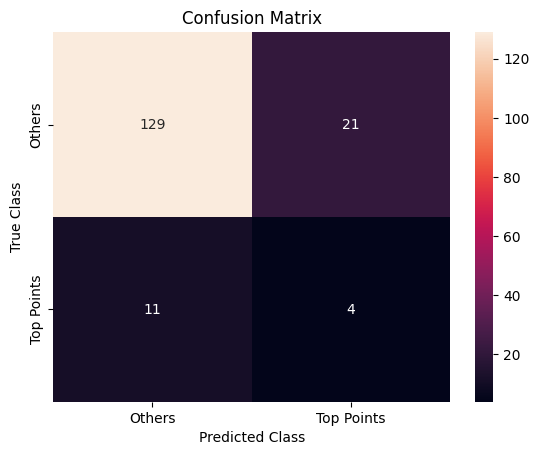

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       150
           1       0.16      0.27      0.20        15

    accuracy                           0.81       165
   macro avg       0.54      0.56      0.54       165
weighted avg       0.85      0.81      0.83       165

KNN: 
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1}
accuracy : 0.9566666666666667
score : 0.8242424242424242


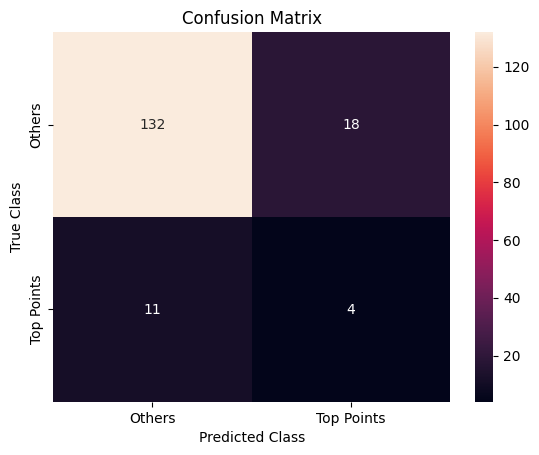

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       150
           1       0.18      0.27      0.22        15

    accuracy                           0.82       165
   macro avg       0.55      0.57      0.56       165
weighted avg       0.86      0.82      0.84       165



In [114]:
model_by_position('Midfielder')

Logistic Regression: 
tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.7536948066803936
score : 0.7741935483870968


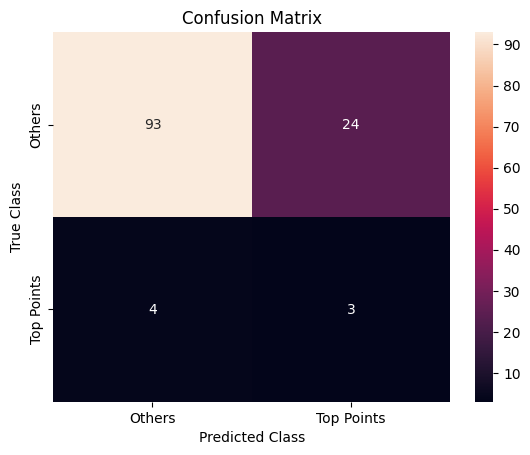

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       117
           1       0.11      0.43      0.18         7

    accuracy                           0.77       124
   macro avg       0.53      0.61      0.52       124
weighted avg       0.91      0.77      0.83       124

SVM: 
tuned hpyerparameters :(best parameters)  {'C': 31.622776601683793, 'gamma': 1.0, 'kernel': 'rbf'}
accuracy : 0.962526766595289
score : 0.9274193548387096


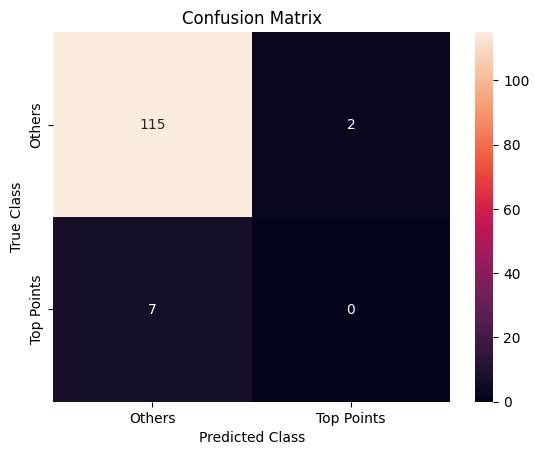

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       117
           1       0.00      0.00      0.00         7

    accuracy                           0.93       124
   macro avg       0.47      0.49      0.48       124
weighted avg       0.89      0.93      0.91       124

Decision Tree: 
tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.934740334019675
score : 0.8951612903225806


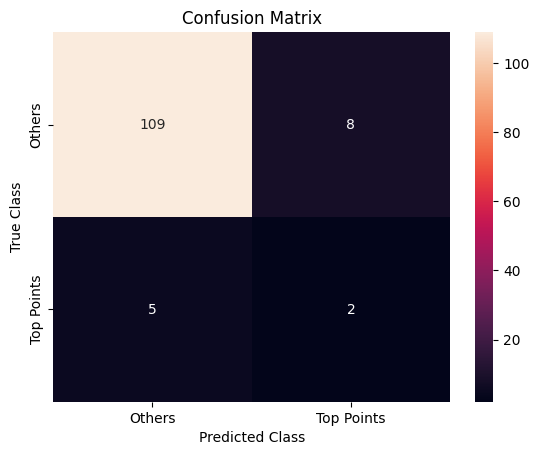

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       117
           1       0.20      0.29      0.24         7

    accuracy                           0.90       124
   macro avg       0.58      0.61      0.59       124
weighted avg       0.91      0.90      0.90       124

KNN: 
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1}
accuracy : 0.9742850606268589
score : 0.9354838709677419


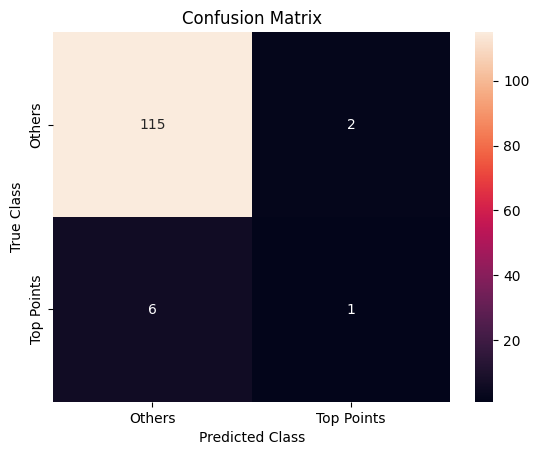

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       117
           1       0.33      0.14      0.20         7

    accuracy                           0.94       124
   macro avg       0.64      0.56      0.58       124
weighted avg       0.92      0.94      0.92       124



In [115]:
model_by_position('Defender')

Logistic Regression: 
tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8400000000000001
score : 0.8214285714285714


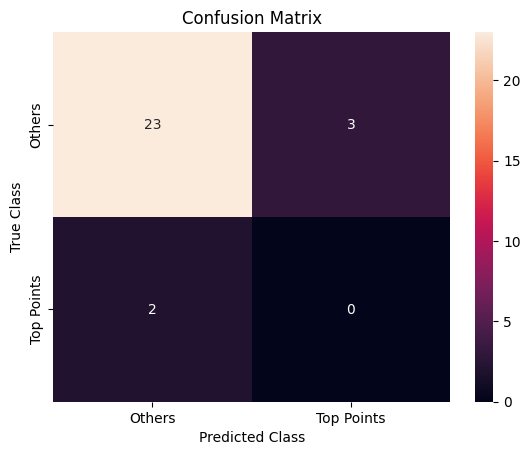

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        26
           1       0.00      0.00      0.00         2

    accuracy                           0.82        28
   macro avg       0.46      0.44      0.45        28
weighted avg       0.85      0.82      0.84        28

SVM: 
tuned hpyerparameters :(best parameters)  {'C': 31.622776601683793, 'gamma': 1.0, 'kernel': 'rbf'}
accuracy : 0.912621359223301
score : 0.8571428571428571


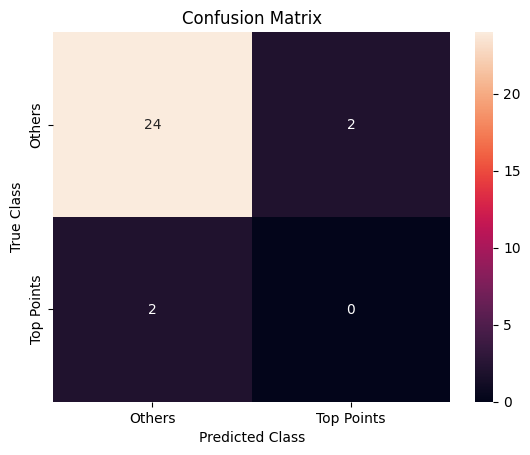

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        26
           1       0.00      0.00      0.00         2

    accuracy                           0.86        28
   macro avg       0.46      0.46      0.46        28
weighted avg       0.86      0.86      0.86        28

Decision Tree: 
tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.9185714285714285
score : 0.9285714285714286


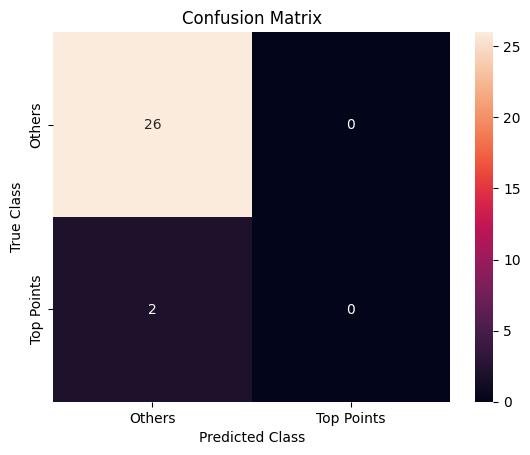

d:\01topan\01goals\goalsenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\01topan\01goals\goalsenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\01topan\01goals\goalsenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           1       0.00      0.00      0.00         2

    accuracy                           0.93        28
   macro avg       0.46      0.50      0.48        28
weighted avg       0.86      0.93      0.89        28

KNN: 
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1}
accuracy : 0.9416666666666667
score : 0.8928571428571429


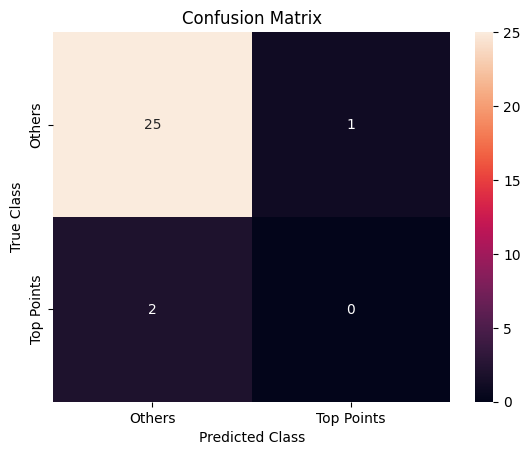

              precision    recall  f1-score   support

           0       0.93      0.96      0.94        26
           1       0.00      0.00      0.00         2

    accuracy                           0.89        28
   macro avg       0.46      0.48      0.47        28
weighted avg       0.86      0.89      0.88        28



In [116]:
model_by_position('Goalkeeper')